# Softmax Regression

Suppose you want to write a program
that will classify handwritten drawing of
digits into their appropriate category: **0**, **1**, **2**, ..., **9**.
You could, think hard about the nature of
digits, try to determine the logic of what
indicates what kind of digit, and write a
program to codify this logic. Or you could take advantage of the **statistics** of the data, e.g. pixel intensity in a 28 x 28 grid, as discriminative features of each instance.
For this task we will use the MNIST dataset:

<img src="img/02-1.png" width=100% title="Title: An elephant">

## ML as data-driven programming

**Machine learning approach.** Collect a training set of images with known labels
and feed these into a machine learning algorithm, which, if done well, will automatically produce a "program" that solves this task. The said program will consist of a large number of [magic numbers](https://en.wikipedia.org/wiki/Magic_number_(programming)), but it nonetheless performs a sequence of computations to determine the output class:

<center> <img src="img/02-2.png" width=100%> </center>

^The latter input is different from training data. In practice, we want the models to perform well on unlabeled data.

## Three elements of a learning algorithm

Every machine learning algorithm has the ff. elements:

| Element | Object | Description |
| :-- | :-- | :-- |
| Hypothesis class | $\mathcal{H}$ | This defines the "program structure". In deep learning, the hypothesis class is parameterized via a set of parameters $\Theta.$ The parameters describe how we map **inputs** (images of digits) to **outputs** (labels, or probabilities for each class). Formally, $\mathcal{H} = \{h_\Theta \mid \Theta \in \mathbb{R}^d \}$ where $h_\Theta(\mathbf{x}) = \hat{y}$ or $\hat{\mathbf{p}}$ for an input $\mathbf{x}.$ |
| Loss function | $\mathcal{L}, \ell$ | A function that specifies how "well" a given **hypothesis** $h_\Theta$ (i.e. a choice of parameters) performs on the task of interest. The loss is expressed in terms of a pointwise **loss function** $\ell$ such that: $$\mathcal{L}_{\mathcal{D}}(\Theta) = \frac{1}{N}\sum_{i=1}^N \ell(h_\Theta(\mathbf{x}_i), y_i)$$ where $\ell \geq 0$ and $\ell \to 0$ whenever the predictions are accurate, and $\ell \to \infty$ as the predictions become increasingly worse. |
| Optimizer | e.g. <br> [`torch.optim.*`](https://docs.pytorch.org/docs/stable/optim.html#how-to-use-an-optimizer), <br> [`LRScheduler`](https://docs.pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate) | Procedure for determining a set of parameters that (approximately) minimizes the training loss. More precisely, the optimizer handles state and the calculation required to find optimal parameters $$\Theta^* \approx {\text{argmin}}_{\Theta} \; \mathcal{L}_\mathcal{D}(\Theta).$$ For deep learning, this is typically an iterative approach via SGD and its variants. |
: Elements of a learning algorithm {tbl-colwidths="[15,20,65]"}

## Multi-class classification

For multi-class classification, the **training dataset** $\mathcal{D}$ consists of input-output pairs
$\mathcal{D} = (\mathbf{x}_i, y_i)_{i=1}^N$ 
where $\mathbf{x}_i \in \mathbb{R}^d$ with $d$ is the **input dimensionality** and $y_i \in [1, K] \subset \mathbb{Z}$ where $K$ is the **number of classes**. Here $N = | \mathcal{D} |$ is the size of the dataset. In this setting, a **hypothesis function** $h$ maps input vectors $\mathbf{x}$ to $K$-dimensional vectors:
$h \colon \; \mathbb{R}^d \to \mathbb{R}^K.$
The output $h_j(\mathbf{x})$ indicates some measure of "belief" in how much likely the label is to be class $j$. That is, the most likely class for an input $\mathbf{x}$ is predicted as the coordinate $\hat{j} = \text{argmax}_j \; h_j(\mathbf{x})$.

**Example.** For MNIST, $d = 28 \times 28 = 784$, $K = 10$ and $M = 60,000.$

## Linear hypothesis class

A **linear hypothesis function** has matrix multiplication as core operation:
$h_\Theta(\mathbf{x}) = \Theta^\top \mathbf{x}$ for parameters $\Theta \in \mathbb{R}^{d \times K}.$ In practice, we usually write this using matrix-batch notation since we process inputs in parallel as a matrix:

$$
h_\Theta(\mathbf{X}) =  \underbrace{\mathbf{X}}_{\mathbb{R}^{M \times d}} \; \underbrace{\Theta}_{\mathbb{R}^{d \times K}} \in \mathbb{R}^{M \times K}
$$

where the inputs are laid out as row vectors inside the matrix:

$$
\begin{equation}
\mathbf{X}=\left[\begin{array}{c}
-\, \mathbf{x}^{(1)\top}- \\
\vdots \\
-\, \mathbf{x}^{(M)\top}-
\end{array}\right] \in \mathbb{R}^{M \times d}
\end{equation}.
$$


**Remark.** Geometrically each $\Theta_j = \Theta_{[:, j]} \in \mathbb{R}^d$ defines a separating hyperplane for class $j \in [K].$ So a linear hypothesis class is able to learn to separate linearly separable data points in $\mathbb{R}^d$ using $K$ separating hyperplanes by assigning a score $s_j = \Theta_j^\top \mathbf{x} \in \mathbb{R}$ proportional to its weighted distance from the hyperplane, and the "weight" of that hyperplane $\lVert\Theta_j\rVert.$

## Loss functions, softmax, and cross-entropy

The simplest loss is just the **zero-one loss**: 
$\ell = 0$ if $\operatorname{argmax}_i h_i(\mathbf{x}) = y$, otherwise $\ell = 1.$
This is just the classification error. Unfortunately, the error is unsuitable for optimization, simply because it is not differentiable. That is, we can smoothly adjust the parameters without seeing a change in $\ell$, or it transitions abruptly from $0$ to $1.$

Instead, we look at the probabilities assigned by the model to each class. To do this, we have to convert the class scores to probabilities exponentiating and
normalizing its entries (i.e. making $\sum_j p = 1$ s.t. $p_j \geq 0$). Class scores $h_j(\mathbf{x}) = \Theta_j^\top \mathbf{x}$ are exponentiated before normalizing:

$$
p_j = \frac{\exp(h_j(\mathbf{x}))}{\sum_l \exp(h_l(\mathbf{x}))} \eqqcolon \text{Softmax} (h(\mathbf{x}))_j.
$$

We can let $\hat{\mathbf{y}}$ be equal to $\mathbf{p} = \text{Softmax} (h(\mathbf{x}))$ since the softmax
approximates the one-hot vector $\mathbf{y}$ of the target label $y$ (see remark below). Then, what is left 
is to define a loss function that captures the difference between the model probability vector and the true
one. For this, we use the **cross-entropy loss** given by the negative log of the probability of the true 
class $y$:

$$
\boxed{
    \begin{aligned}
    \ell_{\text{CE}}(h(\mathbf{x}), y) 
    &= -\log \hat{\mathbf{y}} \odot \mathbf{y}\\[0.8em]
    &= -\log \text{Softmax} (h(\mathbf{x}))_y \\
    &= -h_y(\mathbf{x})+\log \sum_{j=1}^K \exp \left(h_j(\mathbf{x})\right).
    \end{aligned}
}
$$

Here $p_y = 1$ implies $\ell = -\log 1 = 0$ while $p_y = 0$ implies $-\log 0 = +\infty.$ Hence, the model is penalized the more it becomes unconfident in the true class.
Note taking the negative log of the true class suffices to penalize high score in the other classes since we have the constraint $\sum p_j = 1.$ Also, looking at the gradient, the logarithm has the nice property that it does not saturate as it approaches perfect prediction, and it explodes with really bad predictions:

$$\frac{\partial\ell}{\partial p_y} = -\frac{1}{p_y}.$$


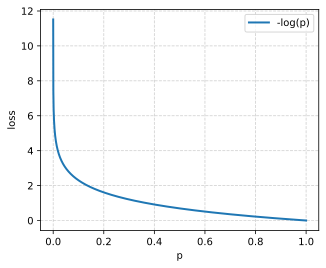

In [1]:
#| code-fold: true
%config InlineBackend.figure_formats = ['svg'] 
import matplotlib.pyplot as plt
import numpy as np

eps = 1e-5
p = np.linspace(0 + eps, 1, 10000)
plt.figure(figsize=(5, 4))
plt.plot(p, -np.log(p), linewidth=2, label="-log(p)")
plt.grid(alpha=0.6, linestyle="dashed")
plt.xlabel("p"); plt.ylabel("loss")
plt.legend();

To further visualize the cross-entropy loss, let's incorporate this graph in the evaluation process. The **baseline loss** is given by $-\log 0.1 \approx 2.30$ assuming uniform prediction across 10 classes. Since the loss decrease more going from $p= 0.1$ to $0.2$ compared to $p = 0.5$ to $0.6$ for the true class, then the optimizer will focus on examples with bad predictions during training. This is desirable behavior.

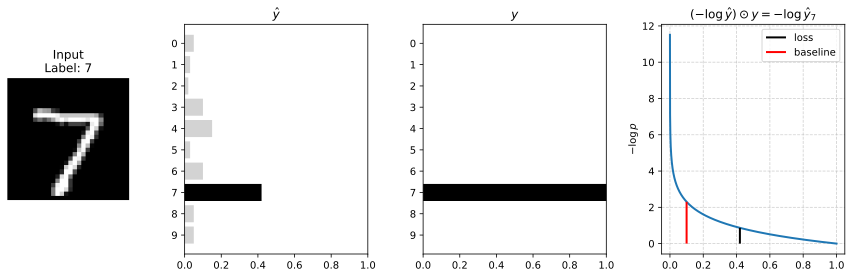

In [2]:
#| echo: false
import matplotlib.pyplot as plt
import numpy as np
from torchvision import datasets, transforms

# Load MNIST using PyTorch
transform = transforms.ToTensor()
mnist = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
img, true_label = mnist[0]  # img is a tensor of shape [1, 28, 28]

# Dummy probability vectors
p1 = [0.05, 0.03, 0.02, 0.1, 0.15, 0.03, 0.1, 0.42, 0.05, 0.05]
p2 = -np.log(np.array(p1)) 
p3 = [0.] * 10
p3[7] = 1.0
labels = [str(i) for i in range(10)]

# Display the MNIST image
fig, ax = plt.subplots(1, 4, figsize=(12, 4), gridspec_kw={'width_ratios': [1, 1.5, 1.5, 1.5]})
ax[0].imshow(img.squeeze(), cmap='gray')
ax[0].axis('off')
ax[0].set_title(f"Input\nLabel: {true_label}")

# Display probability vectors
ax[1].barh(labels, p1, color=["black" if i == 7 else "lightgray" for i in range(10)])
ax[1].set_title(r'$\hat{y}$')
ax[1].invert_yaxis()
ax[1].set_xlim(0, 1)

ax[3].plot(p, -np.log(p), linewidth=2)
x = p1[7]
y = -np.log(p1[7])
baseline = -np.log(0.1)
ax[3].vlines(x, 0, y, color='black', linewidth=2, label="loss")
ax[3].vlines(0.1, 0, baseline, color='red', linewidth=2, label="baseline")
ax[3].legend()
ax[3].grid(alpha=0.6, linestyle="dashed")
ax[3].set_title(r'$(-\log \hat{y}) \odot y = -\log \hat{y}_7$')
ax[3].set_ylabel(r"$-\log p$")


ax[2].barh(labels, p3, color="black")
ax[2].set_title(r'$y$')
ax[2].set_xlim(0, 1)
ax[2].invert_yaxis()

plt.tight_layout()

**Remark.** The softmax can be made to be numerically stable. To see this, notice that 

$$
p_j = \frac{\exp(\Delta h_j(\mathbf{x}))}{\sum_l \exp(\Delta h_l(\mathbf{x}))}
$$

where $\Delta h_l(\mathbf{x}) = h_l(\mathbf{x}) - \max_{m} h_m(\mathbf{x}).$ Thus log-softmax becomes $\log (1 + \sum a_j)$ where $0 < a_j \leq 1$, preventing both underflow and overflow. Moreover, it shows that the individual scores scale exponentially with the difference from the largest score. Hence, this transformation is sometimes called soft-*arg*max since it tends to pick out the largest entry.

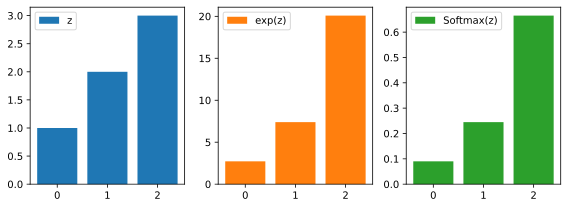

In [3]:
#| code-fold: true
import torch
z = torch.tensor([1, 2, 3]).float()
fig, ax = plt.subplots(1, 3, figsize=(8, 3))
ax[0].bar(range(3), z.numpy(), label="z")
ax[1].bar(range(3), z.exp().numpy(), color="C1", label="exp(z)")
ax[2].bar(range(3), z.exp().numpy() / z.exp().numpy().sum(), color="C2", label="Softmax(z)")
ax[0].legend(); ax[1].legend(); ax[2].legend();
fig.tight_layout()

## Optimization problem

The third ingredient of a machine learning algorithm is a method for solving the
associated optimization problem, i.e. the problem of minimizing the average loss
on the training set:

$$
\hat{\Theta} = \underset{\Theta}{\operatorname{min}} \frac{1}{N} \sum_{i=1}^N \ell_{\text{CE}} (h_\Theta(\mathbf{x}_i), y_i)
$$

How do we find an optimal set of parameters $\hat{\Theta}$? 

### Gradient Descent

For a matrix-input, scalar-output function $f\colon \mathbb{R}^{d \times k} \to \mathbb{R}$ the **gradient** $\nabla_\Theta f(\Theta)$ is defined as the matrix of partial derivatives:

$$
\nabla_\Theta f(\Theta) =\left[\begin{array}{ccc}
\frac{\partial f(\Theta)}{\partial \Theta_{11}} & \cdots & \frac{\partial f(\Theta)}{\partial \Theta_{1 k}} \\
\vdots & \ddots & \vdots \\
\frac{\partial f(\Theta)}{\partial \Theta_{d 1}} & \cdots & \frac{\partial f(\Theta)}{\partial \Theta_{d k}}
\end{array}\right] \in \mathbb{R}^{d \times k}
$$

**NOTE:** $\nabla_\Theta f$ always has the same shape as $\Theta$ when $f$ is a scalar.

From the multivariate Taylor expansion 

$$
f(\Theta + \Delta \Theta) \approx f(\Theta) + \nabla_\Theta f(\Theta) \cdot \Delta\Theta + \mathcal{O}(\Delta\Theta^2).
$$

So that the gradient locally points in the direction that most increases $f$, i.e. to first order. Hence, to minimize $f$, we iteratively update the weight by $-\nabla_\Theta f$ at each point in the surface defined by $f$:

$$
\Theta_{t + 1} = \Theta_t - \alpha \cdot \nabla_\Theta f (\Theta_t)
$$

where $\alpha > 0$ is called the **learning rate**. GD naturally is sensitive to the scale of the learning rate:

<img src=img/02-3.png>

### Stochastic Gradient Descent (SGD)

In practice, we don't typically want to compute the gradient using all examples to make a single update to the parameter. This is costly in cases where $N \gg 1$ which is typical in deep learning. Instead, we take many gradient steps where each update is based on a randomly sampled subset **mini-batch** $\mathcal{B} \subset \mathcal{D}$ where $B = |\mathcal{B}| \ll N.$ At each training step:

1. Sample $\mathcal{B} \subset \mathcal{D}$ so that we get $\mathbf{X}_\mathcal{B} \in \mathbb{R}^{B \times d}$ and $\mathbf{Y} \in [K]^B.$

2. Update parameters: $$\begin{aligned}\Theta_{t + 1}
= \Theta_t - \frac{\alpha}{B} \, \sum_{b \in I_\mathcal{B}} \nabla_\Theta \ell (h_{\Theta_t}(\mathbf{x}_b), y_b).\end{aligned}$$

It follows that the sample dataset varies at each training step. Unlike the previous case where $\mathcal{D}$ is fixed. This mechanism of SGD reduces overfitting by **implicit regularization** of the gradient, i.e. adding noise in the training process.

### Gradient of cross-entropy

How do we actually compute $\mathcal{L}_{\text{CE}}$? 
This can be done using the chain rule and tracking functional dependencies. Recall:

$$
\ell_{\text{CE}}(h_\Theta(\mathbf{x}), y) = -h_\Theta(\mathbf{x})_y + \log \sum_{j=1}^K \exp \left(h_\Theta(\mathbf{x})_j\right).
$$

Let's start by deriving the gradient of the softmax loss itself. For a vector $\mathbf{h} \in \mathbb{R}^K$:

$$
\frac{\partial \ell_{\text{CE}}}{\partial h_j} = - \delta_{yj} + \frac{\exp h_j}{\sum_{l=1}^K \exp h_l} = - \delta_{yj} + p_j.
$$

In vector form, $\nabla_{\mathbf{h}} \ell_{\text{CE}} = \mathbf{p} - \mathbf{y}$ where $\mathbf{y}$ is a one-hot vector with 1 on index $y.$

Next, to calculate the derivative with respect to $\Theta$, we use the chain rule:

$$
\frac{\partial \ell_{\text{CE}}}{\partial \Theta_{ul}} =  \frac{\partial \ell_{\text{CE}}}{\partial h_j} \frac{{\partial h_j}}{\partial \Theta_{ul}} = \underbrace{(p_l - \delta_{yl})}_{K-\text{dim}} \; \underbrace{\vphantom{(}x_u}_{d-\text{dim}}.
$$

For the dimensions to make sense, $\frac{\partial \ell_{\text{CE}}}{\partial \Theta} = \mathbf{x}(\hat{\mathbf{y}} - \mathbf{y})^\top$ in matrix form. Recall that our vectors are column vectors and $\hat{\mathbf{y}} = \mathbf{p}.$ Here the product reverses since we traverse the dependence backwards from the loss. 

**Batch form.** The same process works for a batch of inputs, except that we have an additional batch index which we sum over since $\ell$ depends on all input instances. The contribution of each input is matched and aggregated using matrix multiplication:

$$
\frac{\partial \mathcal{L}_{\text{CE}}}{\partial \Theta} = \frac{1}{B}\,\underbrace{\vphantom{(}\mathbf{X}^\top}_{d \times M} \;\; \underbrace{(\hat{\mathbf{Y}} - \mathbf{Y})}_{M \times K}.
$$

Here the transposes switched since $\mathbf{X}$ is constructed such that it has rows of $\mathbf{x}^\top,$ hence we internally get a double transpose. Putting it all together, we can write the SGD update rule for softmax regression as follows:

$$
\Theta_{t + 1} = \Theta_t - \frac{\alpha}{B} \; \mathbf{X}^\top (\hat{\mathbf{Y}} - \mathbf{Y}).
$$

Here we have $\frac{1}{B}$ since $\mathcal{L} = \frac{1}{B}\sum_b { \ell}_b.$ Also it makes sense to scale down since the sum grows with batch size $B.$ Finally, notice that the step size becomes smaller as $\| \hat{\mathbf{Y}} - \mathbf{Y} \| \to 0.$ To recap, we have the following equations:

$$
\boxed{
\begin{aligned}
\frac{\partial \mathcal{L}_{\text{CE}}}{\partial \mathbf{H}} &= \frac{1}{B}  (\hat{\mathbf{Y}} - \mathbf{Y}) \\[0.75em]
\frac{\partial \mathcal{L}_{\text{CE}}}{\partial \Theta} &= \frac{1}{B} \mathbf{X}^\top  (\hat{\mathbf{Y}} - \mathbf{Y}) \\[0.60em]
\Theta_{t + 1} &= \Theta_t - \frac{\alpha}{B} \, \mathbf{X}^\top (\hat{\mathbf{Y}} - \mathbf{Y})
\end{aligned}
}
$$

## Code implementation

We will train a classification model based on the SGD update rule above:

In [4]:
import torch
from torchvision import datasets, transforms

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))  # MNIST mean and std
])

train_dataset = datasets.MNIST('./data', train=True,  transform=transform)
valid_dataset = datasets.MNIST('./data', train=False, transform=transform)

Defining the linear model:

In [5]:
import torch.nn as nn
model = nn.Linear(784, 10, bias=False)

**Remark.** The linear model can be extended to have a bias vector $\beta$, so that  $h_\Theta = \mathbf{X}\Theta + \beta$ where $\beta \in \mathbb{R}^K.$ But it turns out there is a "bias trick" in deep learning where an additional dimension containing only $+1$ is added so that the input becomes of shape $(N, d + 1).$ For simplicity, we stick with no bias.

In [6]:
from torch.utils.data import DataLoader
from tqdm import tqdm
import torch.nn.functional as F

loss_train = []
N_EPOCHS = 5
B = 16
ALPHA = 0.01

@torch.no_grad()
def train_step(x, y):
    x = x.reshape(-1, 784)
    h = model(x)

    for theta in model.parameters():
        p = F.softmax(h, dim=1)
        e = F.one_hot(y, num_classes=10)
        g = x.T @ (p - e) / B

        theta -= ALPHA * g.T

    loss = -p[torch.arange(B), y].log().mean()
    return loss.item()


dl = DataLoader(train_dataset, batch_size=B, shuffle=True)  # SGD!
for _ in tqdm(range(N_EPOCHS)):
    for x, y in dl:
        loss = train_step(x, y)
        loss_train.append(loss)

  0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 5/5 [00:17<00:00,  3.50s/it]


**Remark.** Pytorch `nn.Linear` computes `x @ θ.T + b`. Hence, we take `g.T` before updating the parameter `θ`.

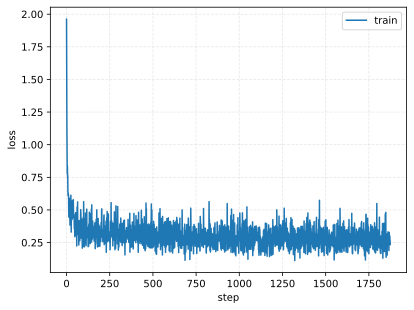

In [7]:
#| code-fold: true
plt.plot(np.array(loss_train).reshape(-1, 10).mean(1), label="train")
plt.xlabel("step")
plt.ylabel("loss")
plt.grid(alpha=0.3, linestyle="dashed")
plt.legend();

Label prediction sample:

In [8]:
dv = DataLoader(valid_dataset, batch_size=B, shuffle=False)
x, y = next(iter(dv))
out = model(x.reshape(B, -1)).argmax(1)
acc = (out == y).float()
print("Batch acc:", f"{acc.sum().int()}/{B}", f"({acc.mean().item() * 100}%)")

Batch acc: 15/16 (93.75%)


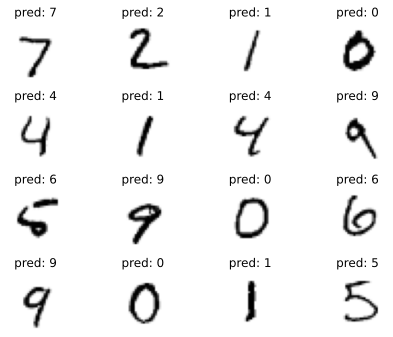

In [9]:
#| code-fold: true
fig, ax = plt.subplots(4, 4)
for i in range(B):
    a, b = divmod(i, 4)
    ax[a, b].imshow(x[i].reshape(28, 28), cmap="Greys")
    ax[a, b].set_title(f"pred: {out[i]}")
    ax[a, b].axis("off")

fig.tight_layout()

**Evals.** The practical goal of training is not actually to minimize $\mathcal{L}_\mathcal{D}(\Theta).$ But to minimize the loss for samples outside of the training dataset. That is, the model should be accurate on **test data**. If the model does not [overfit](https://en.wikipedia.org/wiki/Overfitting) and the test distribution does not drift too far from the training distribution, then we should be good. 

In [10]:
tot = 0
acc = 0
for x, y in dv:
    out = model(x.reshape(B, -1)).argmax(1)
    correct = (out == y).float()
    tot += len(y)
    acc += correct.sum()

print(f"Test acc: {acc / tot * 100:.2f}%")

Test acc: 92.23%


## Appendix: Model complexity


Since SGD relies on a stochastic process, the performance of the resulting trained model varies. How are we sure that we aren't just lucky for this particular run / random seed? What is the variance of the trained model performance over multiple runs? Is there a way to control this? This issue is at the core of learning theory and precisely what the [Bias-Variance Tradeoff](https://www.cs.cornell.edu/courses/cs4780/2018fa/lectures/lecturenote12.html) addresses. 

In practice, the crucial parameter to control is **model complexity**. Here **model capacity** or **complexity** is a measure of how complicated a pattern or relationship a model architecture can express. Let $f$ be the true function that underlies the task. If model capacity is sufficiently large, the **model class** $\mathcal{F} = \{f_{\Theta} \mid \Theta \in \mathbb{R}^d \}$ contains an approximation $\hat{f} \in \mathcal{F}$ such that $\| f - \hat{f} \| < \epsilon$ for a small enough $\epsilon > 0.$

The capacity of a model class can be controlled, for example, by the number of learnable parameters in practical architectures. It can also be constrained directly by applying **regularization** or certain **prior knowledge** such as invariances. This biases the model towards certain solutions, so these constraints are sometimes referred to as **inductive biases** &mdash; such knowledge is bias in the sense that it makes some solutions more likely, and others less likely. The tradeoff is that the model are steered to biased solutions more efficiently. 